**Instituto de Informática - UFG**

Disciplina: Inteligência Artificial

Prof. Cedric Luiz de Carvalho

Grupo ( A )

---


Aluna(o): Luana Guedes Barros Martins

---

Aluna(o): Ruan Chaves Rodrigues

---

Aluna(o): Thiago Monteles de Souza

---

# Atividade Prática 03 - Redes Bayesianas

## Tratamento de dados: Ruan Chaves Rodrigues

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

import pandas as pd
import numpy as np 
import seaborn as sns
import math
from collections import defaultdict
import random

from sklearn.metrics import confusion_matrix

import pydotplus
from IPython.display import Image, display, SVG

from tensorflow.python.keras.utils.vis_utils import model_to_dot

In [2]:
"""
# Carregar o dataset "baseDeDados.csv" para o ambiente virtual

from google.colab import files
uploaded = files.upload()
"""

'\n# Carregar o dataset "baseDeDados.csv" para o ambiente virtual\n\nfrom google.colab import files\nuploaded = files.upload()\n'

In [3]:
df = pd.read_csv('baseDeDados.csv', sep=';')

Dado que:

"Um aluno com bom desempenho é aquele que se forma em até 4 anos e meio ou se forma com média igual ou superior a 7 ou se forma com número de reprovações igual inferior a 5."

Temos:

\begin{equation*}
A \lor ( B \land C ) \lor ( B \land D )
\end{equation*}

Sendo:

**A:** O aluno se forma em 4 anos e meio.

**B:** O aluno se formou. 

**C:** O aluno tem média igual ou superior a 7.

**D:** O aluno tem número de reprovações igual ou inferior a 5.

Serão desconsiderados alunos que ingressaram há menos de 4 anos e meio atrás ( depois de 2015.1 ).

O campo "media_global_atual_discente" contém valores NaN. Iremos tratar este campo considerando uma média global calculada nas posições onde este campo apresenta NaN.

In [4]:
alunos = df[['id', \
             'ano_periodo_ingresso', \
             'data_colacao_grau', \
             'media_global_atual_discente']]\
.rename(columns={'id': 'identificador'})

media_global = df[['id', \
                   'nota_discente_componente']]\
.rename(columns={'id': 'identificador'})\
.dropna()\
.groupby(by=['identificador'])\
.mean()\
.rename(columns={'nota_discente_componente': 'media_global_calculada'})

alunos = pd.merge(alunos, \
                  media_global, \
                  how='outer', \
                  on='identificador')

alunos['media_global_considerada'] = alunos['media_global_atual_discente'].\
combine(alunos['media_global_calculada'], lambda x,y: x if not math.isnan(x) else y )

Vamos contar a quantidade de reprovações de cada aluno.

In [5]:
alunos['reprovacoes'] = 0

cols = ['quantidade_reprovacoes_nc', \
        'quantidade_reprovacoes_nl', \
        'quantidade_reprovacoes_neobr', \
        'quantidade_reprovacoes_neopt']

for item in cols:
     alunos['reprovacoes'] += df[item].fillna(0)

Iremos desconsiderar alunos que ingressaram há menos de 4 anos e meio atrás: depois de 2015.1.

In [6]:
alunos = alunos[alunos['ano_periodo_ingresso'] < 2015.1 ]

Agora iremos calcular a expressão \begin{equation*} A \lor ( B \land C ) \lor ( B \land D ) \end{equation*} e armazenar o valor no campo **classificacao_final**.

In [7]:
alunos['classificacao_1'] = 0
alunos['classificacao_2'] = 0
alunos['classificacao_3'] = 0
alunos['classificacao_final'] = 0

# Se forma em até quatro anos e meio

alunos['data_colacao_grau'] = alunos['data_colacao_grau'].fillna('0-0-0')

alunos['data_colacao_grau'] = alunos['data_colacao_grau'].\
apply(lambda x: int(x.split('-')[0]) + 0.1 * (int(x.split('-')[1]) < 7) + 0.2 * (int(x.split('-')[1]) > 7)  )

alunos['diff'] = alunos['data_colacao_grau'] - alunos['ano_periodo_ingresso']

alunos['classificacao_1'] = alunos['diff'].\
apply(lambda x: 1 if ( x <= 4.5 and x > 0 ) else 0)

alunos = alunos.drop_duplicates()

# se forma

alunos['formado'] = alunos['diff'].\
apply(lambda x: 1 if x > 0 else 0)

# "se forma E tem média igual ou superior a 7"

alunos['classificacao_2'] = alunos['media_global_considerada'].\
apply(lambda x: 1 if x >= 7 else 0 ).\
combine(alunos['formado'], lambda x,y: 1 if x & y else 0 )

# # "se forma E tem número de reprovações igual inferior a 5."

alunos['classificacao_3'] = alunos['reprovacoes'].\
apply(lambda x: 1 if x <= 5 else 0 ).\
combine(alunos['formado'], lambda x,y: 1 if x & y else 0 )

# classificacao final

alunos['classificacao_final'] = alunos['classificacao_1'].\
combine(alunos['classificacao_2'], lambda x,y: 1 if x | y else 0 ).\
combine(alunos['classificacao_3'], lambda x,y: 1 if x | y else 0 )

alunos.sample(10)

,identificador,ano_periodo_ingresso,data_colacao_grau,media_global_atual_discente,media_global_calculada,media_global_considerada,reprovacoes,classificacao_1,classificacao_2,classificacao_3,classificacao_final,diff,formado
14134,405,2013.2,0.1,NaN,1.225000,1.225000,5.0,0,0,0,0,-2013.1,0
11531,333,2012.1,0.1,2.93,2.938889,2.930000,25.0,0,0,0,0,-2012.0,0
8391,235,2011.1,0.1,NaN,5.050000,5.050000,2.0,0,0,0,0,-2011.0,0
746,20,2008.1,2013.2,NaN,5.607273,5.607273,13.0,0,0,0,0,5.1,1
1471,39,2008.1,0.1,NaN,3.641379,3.641379,23.0,0,0,0,0,-2008.0,0
6334,176,2010.2,2018.1,5.22,5.201639,5.220000,25.0,0,0,0,0,7.9,1
8820,252,2011.2,2017.1,7.69,7.734146,7.690000,0.0,0,1,1,1,5.9,1
10747,307,2012.1,0.1,1.71,1.837500,1.710000,8.0,0,0,0,0,-2012.0,0
9850,285,2011.1,2017.2,5.47,5.397959,5.470000,30.0,0,0,0,0,6.1,1
2894,73,2009.1,0.1,4.51,3.373333,4.510000,38.0,0,0,0,0,-2009.0,0


Iremos descartar do treinamento as disciplinas que não pertencem aos dois primeiros períodos.

In [8]:
disciplinas = df[['matriz_semestre_previsto_cursar_compomente', 'nome_componente']].\
drop_duplicates().\
rename(columns={'matriz_semestre_previsto_cursar_compomente': 'semestre_previsto'})

disciplinas['num_semestre'] = disciplinas['semestre_previsto'].\
apply(lambda x: int(x.split('/')[1][0]) )

disciplinas = disciplinas[disciplinas['num_semestre'] <= 2]

# somente da grade antiga
disciplinas = disciplinas[disciplinas['semestre_previsto'].str.contains('CICOMP-BI-2')]

disciplinas

,semestre_previsto,nome_componente,num_semestre
0,CICOMP-BI-2/1-IME0073,CÁLCULO 1,1
1,CICOMP-BI-2/1-INF0131,LÓGICA MATEMÁTICA,1
2,CICOMP-BI-2/1-INF0135,MATEMÁTICA DISCRETA,1
3,CICOMP-BI-2/2-IFI0105,FÍSICA PARA COMPUTAÇÃO,2
4,CICOMP-BI-2/2-IME0006,ÁLGEBRA LINEAR,2
6,CICOMP-BI-2/2-IME0078,CÁLCULO 2,2
7,CICOMP-BI-2/2-INF0157,PROGRAMAÇÃO DE COMPUTADORES 2 CN,2
8,CICOMP-BI-2/2-INF0195,SISTEMAS DIGITAIS,2
58,CICOMP-BI-2/1-INF0109,INTRODUÇÃO À COMPUTAÇÃO,1
60,CICOMP-BI-2/1-INF0156,PROGRAMAÇÃO DE COMPUTADORES 1 CN,1


Observaremos a nota de cada aluno na n-ésima tentativa de passar na disciplina.

In [9]:
disciplinas = disciplinas[['nome_componente']]

identificadores = alunos[['identificador']]
notas = pd.merge(df[['id', 'nome_componente', 'nota_discente_componente']].\
                       rename(columns={'id': 'identificador'}),\
                       identificadores, how='outer', on='identificador')

# enumerar linhas repetidas

notas['componente_enum'] = notas[['identificador', 'nome_componente']].\
groupby(by=['identificador', 'nome_componente']).\
cumcount()+1

notas.head()

,identificador,nome_componente,nota_discente_componente,componente_enum
0,1,CÁLCULO 1,7.3,1
1,1,LÓGICA MATEMÁTICA,6.8,1
2,1,MATEMÁTICA DISCRETA,5.0,1
3,1,FÍSICA PARA COMPUTAÇÃO,5.0,1
4,1,ÁLGEBRA LINEAR,4.2,1


### Atribuição de Valores a pares aluno/matéria

Seja "bom aluno" o aluno que possui bom desempenho.

Considere um aluno qualquer $a$ e uma matéria $m$.

A este par ($a$, $m$) iremos atribuir as variáveis $X_{a,m}$ e $Y_{a,m}$.

$X_{a,m}$ estará no campo **companhia** e $Y_{a,m}$ estará no campo **media_ponderada**. 

$X_{a,m}$ mede o quanto o aluno $a$ está na companhia de bons alunos, e $Y_{a,m}$ mede qual o desempenho do aluno $a$ comparado aos bons alunos.

Explicando informalmente, a variável $X_{a,m}$ responde a pergunta: *"Quantos bons alunos tinham na turma da matéria $m$ em que $a$ foi aprovado, e que já tinham tentado passar nessa matéria a mesma quantidade de vezes que ele?"*. 


Seja $T_{m,n}$ a quantidade de bons alunos que passaram na matéria $m$ na $n$-ésima tentativa, e $U_m$ a quantidade total de bons alunos que já cursaram a matéria $m$.
Então:

$$P_{m,n} = \frac{T_{m,n}}{U_m}$$

Seja $f_{a,m}$ uma função que retorna a quantidade de tentativas que o aluno $a$ realizou para passar na matéria $m$.

Seja $g_{a,m}$ uma função booleana que retorna 1 caso o aluno $a$ tenha sido aprovado na matéria $m$, e 0 caso ele tenha reprovado na matéria $m$ mesmo após todas as suas tentativas. Então:

$$X_{a,m} = P_{m,f_{a,m}} * g_{a,m} $$


O modelo Bernoulli Naive Bayes, quando deve receber $X_{a,m}$ como entrada, realiza a binarização de seus valores e recebe $b(X_{a,m})$:

$$ b(X_{a,m}) = \lfloor X_{a,m} + 0,5 \rfloor$$

Seja $M_{m,n}$ a média geral dos bons alunos que cursaram a matéria $m$ por $n$ vezes.

Seja $N_{a,n}$ a nota do aluno $a$ na $n$-ésima tentativa de passar na matéria.


Então:
\begin{equation*}
Y_{a,m} = \frac{\sum_{i=1}^{f(a,m)} P_{m,i} * D_{a,m,i} }{\sum_{i=1}^{f(a,m)} P_{m,i}}
\end{equation*}

Sendo $D_{a,m,n}$ o desvio normalizado: $$D_{a,m,n} = \frac{( N_{a,n} - M_{m,n} ) + 10}{20}$$

In [10]:
# Identificadores de bons alunos

identificadores = alunos[['identificador', 
                          'classificacao_final']]

identificadores = identificadores[identificadores['classificacao_final'] == 1]\
[['identificador']]

# Qual a média dos bons alunos que fizeram essa matéria pela n-ésima vez?

medias = pd.merge(identificadores, 
                  notas, 
                  how='inner', 
                  on='identificador')\
[['nome_componente', 'componente_enum', 'nota_discente_componente']]\
.groupby(by=['nome_componente', 'componente_enum'])\
.mean()\
.reset_index([0,-1])\
.rename(columns={'nota_discente_componente' : 'media'})

medias.head()

,nome_componente,componente_enum,media
0,ANÁLISE E PROJETO DE ALGORITMOS,1,6.735211
1,ANÁLISE E PROJETO DE ALGORITMOS,2,5.744444
2,ANÁLISE E PROJETO DE ALGORITMOS,3,8.650000
3,ARQUITETURA DE COMPUTADORES,1,7.621875
4,ARQUITETURA DE COMPUTADORES,2,7.366667


In [11]:
# Qual porcentagem de bons alunos fizeram essa matéria pela n-ésima vez?

notas_bons_alunos = pd.merge(identificadores, 
                             notas, 
                             how='inner', 
                             on='identificador')

notas_bons_alunos['contagem'] = 1.0

soma = notas_bons_alunos\
.groupby(by=['nome_componente', 'componente_enum'])\
.agg({'contagem': 'sum'})\
.groupby(level=0)\
.apply(lambda x: x / x.sum() )\
.reset_index([0,-1])

bons_alunos = medias[['nome_componente', 'componente_enum']]
bons_alunos = pd.merge(bons_alunos, 
                       soma, 
                       how='outer', 
                       on=['nome_componente', 'componente_enum'])\
.fillna(0.0)\
.rename(columns={'contagem': 'porcentagem'})

bons_alunos = pd.merge(bons_alunos,
                      medias,
                      how='outer',
                      on=['nome_componente', 'componente_enum'])


bons_alunos

,nome_componente,componente_enum,porcentagem,media
0,ANÁLISE E PROJETO DE ALGORITMOS,1,0.865854,6.735211
1,ANÁLISE E PROJETO DE ALGORITMOS,2,0.109756,5.744444
2,ANÁLISE E PROJETO DE ALGORITMOS,3,0.024390,8.650000
3,ARQUITETURA DE COMPUTADORES,1,0.955224,7.621875
4,ARQUITETURA DE COMPUTADORES,2,0.044776,7.366667
5,BANCO DE DADOS,1,0.888889,6.739063
6,BANCO DE DADOS,2,0.111111,6.712500
7,COMPILADORES,1,0.936709,6.913514
8,COMPILADORES,2,0.050633,5.275000
9,COMPILADORES,3,0.012658,6.700000


In [12]:
def preprocessamento(notas, disciplinas, bons_alunos):
    # Vamos produzir os pares (aluno, materia).
    dados_finais = notas[['identificador',
                      'nome_componente',
                      'componente_enum',
                      'nota_discente_componente']]
    # Eliminar disciplinas fora do segundo período da grade antiga.
    dados_finais = pd.merge(dados_finais,
                        disciplinas[['nome_componente']],
                        how='inner',
                        on='nome_componente')
    
    # Colocar valores de bons_alunos na tabela ( 'media' e 'porcentagem' ).
    dados_finais = pd.merge(dados_finais,
                        bons_alunos,
                        how='inner',
                        on=['nome_componente', 'componente_enum'])\
    .sort_values(by=['identificador', 'nome_componente'])
    
    # Cálculo do desvio.
    dados_finais['desvio'] = dados_finais['nota_discente_componente'] - dados_finais['media']
    dados_finais['desvio'] += 10
    dados_finais['desvio'] /= 20
    return dados_finais


# Calcular a média ponderada em cada grupo ( o Y de cada par (a,m) ).

def media_ponderada(grupo, nome, peso):
    n = grupo[nome]
    p = grupo[peso]
    return (n * p).sum() / p.sum()

def gerar_valores(dados_finais):
    
    mp = dados_finais\
    .groupby(by=['identificador', 'nome_componente'])\
    .apply(media_ponderada,'desvio','porcentagem')\
    .reset_index([0,-1])\
    .rename(columns={0: 'media_ponderada'})
    
    # Calcular porcentagem mínima em cada par (a,m).
    porcentagem_minima = dados_finais[['identificador',
                                    'nome_componente',
                                    'porcentagem']]\
    .groupby(by=['identificador', 'nome_componente'])\
    .apply(lambda x: x.min())\
    [['porcentagem']]\
    .reset_index()\
    .rename(columns={"porcentagem" : "porcentagem_minima"})
    
    # Calcular nota máxima em cada par (a,m).
    nota_maxima = dados_finais[['identificador',
                                    'nome_componente',
                                    'nota_discente_componente']]\
    .groupby(by=['identificador', 'nome_componente'])\
    .apply(lambda x: x.max())\
    [['nota_discente_componente']]\
    .reset_index()\
    .rename(columns={"nota_discente_componente" : "nota_maxima"})
    
    dados_finais = pd.merge(mp, 
                        dados_finais, 
                        how='inner', 
                        on=['identificador', 'nome_componente'])
    
    dados_finais = pd.merge(porcentagem_minima, 
                        dados_finais, 
                        how='inner', 
                        on=['identificador', 'nome_componente'])
    
    dados_finais = pd.merge(nota_maxima,
                       dados_finais,
                       how='inner',
                       on=['identificador', 'nome_componente'])\
    .sort_values(by=['identificador', 'nome_componente', 'componente_enum'])\
    [['identificador',
      'nome_componente',
      'componente_enum',
      'porcentagem_minima',
      'nota_maxima',
      'media_ponderada',
      'porcentagem',
      'desvio',
      'nota_discente_componente',
      'media']]
    
    dados_finais['companhia'] = dados_finais['nota_maxima']\
    .apply(lambda x: 0 if x < 6 else 1)\
    .mul(dados_finais['porcentagem_minima'])
    
    return dados_finais

dados_finais = preprocessamento(notas, disciplinas, bons_alunos)
dados_finais = gerar_valores(dados_finais)
dados_finais.head(30)

,identificador,nome_componente,componente_enum,porcentagem_minima,nota_maxima,media_ponderada,porcentagem,desvio,nota_discente_componente,media,companhia
0,1,CÁLCULO 1,1,0.838235,7.3,0.540614,0.838235,0.540614,7.3,6.487719,0.838235
1,1,CÁLCULO 2,1,0.845070,5.2,0.443167,0.845070,0.443167,5.2,6.336667,0.000000
2,1,FÍSICA PARA COMPUTAÇÃO,1,0.923077,5.0,0.398583,0.923077,0.398583,5.0,7.028333,0.000000
3,1,LÓGICA MATEMÁTICA,1,0.969231,6.8,0.448968,0.969231,0.448968,6.8,7.820635,0.969231
4,1,MATEMÁTICA DISCRETA,1,1.000000,5.0,0.374833,1.000000,0.374833,5.0,7.503333,0.000000
5,1,PROGRAMAÇÃO DE COMPUTADORES 2 CN,1,1.000000,6.0,0.377063,1.000000,0.377063,6.0,8.458730,1.000000
6,1,SISTEMAS DIGITAIS,1,0.885714,6.3,0.468952,0.885714,0.468952,6.3,6.920968,0.885714
7,1,ÁLGEBRA LINEAR,1,0.138889,6.9,0.418681,0.861111,0.404274,4.2,6.114516,0.138889
8,1,ÁLGEBRA LINEAR,2,0.138889,6.9,0.418681,0.138889,0.508000,6.9,6.740000,0.138889
9,2,CÁLCULO 1,1,0.161765,7.2,0.398750,0.838235,0.375614,4.0,6.487719,0.161765


In [13]:
def criar_lacunas(dados_finais, disciplinas):
    # Já chegamos aos dados finais. Nesta célula, iremos somente inserir 
    # as lacunas para valores desconhecidos ( matérias que o aluno não fez ).
    
    # disciplinas do primeiro e segundo períodos
    check_disc = [ x['nome_componente'] for x in list(disciplinas.T.to_dict().values()) ]
    
    # lista de alunos nos dados finais
    check_ids = [ x['identificador'] for x in list(dados_finais.T.to_dict().values())]
    
    # eliminação de duplicatas
    check_ids = [ v for i,v in enumerate(check_ids) if check_ids.index(v) == i ]
    check_disc = [ v for i,v in enumerate(check_disc) if check_disc.index(v) == i ]
    
    # tabela de (aluno, materia), considerando inclusive matérias
    # que não foram feitas pelo aluno
    table = []
    for idx in check_ids:
        for d in check_disc:
            row = {}
            row['identificador'] = idx
            row['nome_componente'] = d
            table.append(row)
            
    resultado = pd.merge( pd.DataFrame(table),
                         dados_finais,
                         how='outer',
                         on=['identificador', 'nome_componente'])\
    .sort_values(by=['identificador', 'nome_componente'])
    return resultado
            
def adicionar_classificacao(resultado, alunos):
    # Iremos colocar classificacao_final como uma coluna do nosso resultado.
    resultado = \
    pd.merge(resultado, alunos[['identificador',
                            'classificacao_final']],
                     how='inner',
                     on='identificador')\
    .sort_values(by=['identificador', 'nome_componente'])        
    return resultado

# A ausência da linha abaixo, que estava ausente em versões passadas deste trabalho, 
# causava um erro no pré-processamento dos dados.
dados_finais = dados_finais.drop_duplicates(subset=['identificador', 
                                                    'nome_componente'])
resultado = criar_lacunas(dados_finais, disciplinas)
resultado = adicionar_classificacao(resultado, alunos)
resultado

,identificador,nome_componente,componente_enum,porcentagem_minima,nota_maxima,media_ponderada,porcentagem,desvio,nota_discente_componente,media,companhia,classificacao_final
0,1,CÁLCULO 1,1.0,0.838235,7.3,0.540614,0.838235,0.540614,7.3,6.487719,0.838235,0
1,1,CÁLCULO 2,1.0,0.845070,5.2,0.443167,0.845070,0.443167,5.2,6.336667,0.000000,0
2,1,FÍSICA PARA COMPUTAÇÃO,1.0,0.923077,5.0,0.398583,0.923077,0.398583,5.0,7.028333,0.000000,0
3,1,INTRODUÇÃO À COMPUTAÇÃO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1,LÓGICA MATEMÁTICA,1.0,0.969231,6.8,0.448968,0.969231,0.448968,6.8,7.820635,0.969231,0
5,1,MATEMÁTICA DISCRETA,1.0,1.000000,5.0,0.374833,1.000000,0.374833,5.0,7.503333,0.000000,0
6,1,PROGRAMAÇÃO DE COMPUTADORES 1 CN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
7,1,PROGRAMAÇÃO DE COMPUTADORES 2 CN,1.0,1.000000,6.0,0.377063,1.000000,0.377063,6.0,8.458730,1.000000,0
8,1,SISTEMAS DIGITAIS,1.0,0.885714,6.3,0.468952,0.885714,0.468952,6.3,6.920968,0.885714,0
9,1,ÁLGEBRA LINEAR,1.0,0.138889,6.9,0.418681,0.861111,0.404274,4.2,6.114516,0.138889,0


In [14]:
# Converter os dados do formato de dataframe para vetores.
ids = np.array(resultado['identificador'])
ids = [ i for i,v in enumerate(ids[0:-1]) if ids[i] != ids[i+1] ]
ids = [0] + [ x+1 for x in ids]

select_column = lambda x: np.array([ np.array(resultado[x])[ids[i]:ids[i+1]] \
                           for i in range(len(ids)-1) ])

companhia = select_column('companhia')
media_ponderada = select_column('media_ponderada')
classificacao = select_column('classificacao_final')

In [15]:
# -- Aplicando testes de consistência aos dados

# A soma dos valores únicos de cada coluna da matriz em "companhia" e "media_ponderada" 
# deve ser igual a 1.


def sum_to_1(df):
    for col in df.columns:
        assert(0.99 <= np.float64(sum(df[col].drop_duplicates().dropna().values)))

sum_to_1(pd.DataFrame(media_ponderada))
sum_to_1(pd.DataFrame(companhia))

# Todos os valores de cada vetor em classificacao devem ser ou 0 ou 1.

def unique_values(lst):
    for row in lst:
        assert(len(set(row)) == 1)

unique_values(classificacao)

# Todas as matrizes devem ter as mesmas dimensões.

assert(pd.DataFrame(media_ponderada).shape == \
      pd.DataFrame(companhia).shape == \
      pd.DataFrame(classificacao).shape)

In [16]:
# Unificando os vetores.

classificacao = np.array([ np.array([x[0]]) for x in classificacao ])
features = np.concatenate((companhia, media_ponderada, classificacao), axis=1)

### Heatmap

O *heatmap* abaixo nos permite visualizar a força de correlação entre as nossas variáveis. 

Ele representa os dados tal como são fornecidos à árvore de decisão.

**Linhas**: Cada linha representa um aluno.

**Colunas 0~9**: As colunas de 0 a 9 representam valores de $X_{a,m}$ para cada uma das dez matérias consideradas.

**Colunas 10~19:** As colunas de 10 a 19 representam valores de $Y_{a,m}$ para cada uma das dez matérias consideradas.

Observe que as matérias estão em ordem. Assim, a coluna 0 corresponde à mesma matéria da coluna 10, a 1 corresponde à 11, e assim por diante.

**Coluna 20:** Cor clara para aluno com bom desempenho, cor escura para aluno sem bom desempenho.

Observe que a coluna 20 traça uma linha horizontal no *heatmap* que separa os bons alunos dos demais. Os bons alunos tendem a ser representados por linhas de tonalidade mais clara que os demais.

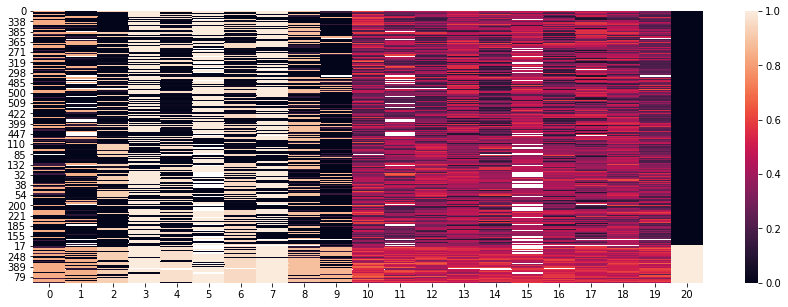

In [17]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 5]

sns.heatmap(pd.DataFrame(features).sort_values(by=20))

### Preenchimento 


Para valores vazios, preenchemos os valores de $X_{a,m}$ com a **moda** da coluna e os valores de $Y_{a,m}$ com a **média** da coluna.  

Esta média e esta moda são calculadas levando em conta somente os alunos de mesma classificação que o aluno ao qual pertence o valor vazio.

In [18]:
good = pd.DataFrame(features)
bad = pd.DataFrame(features)

good = good[good[20]==1]
bad = bad[bad[20]==0]

def nan_to_mode(table,modes):
    for idx, column in enumerate(table.columns):
        if idx < 10:
            table[column] = table[column].fillna(modes[idx])
        else:
            table[column] = table[column].fillna(table[column].mean())
    return table

modes = good.mode(dropna=True).iloc[0].values.tolist()
good = nan_to_mode(good, modes)
modes = bad.mode(dropna=True).iloc[0].values.tolist()
bad = nan_to_mode(bad, modes)

filled_features = list(good.values.tolist()) + list(bad.values.tolist())

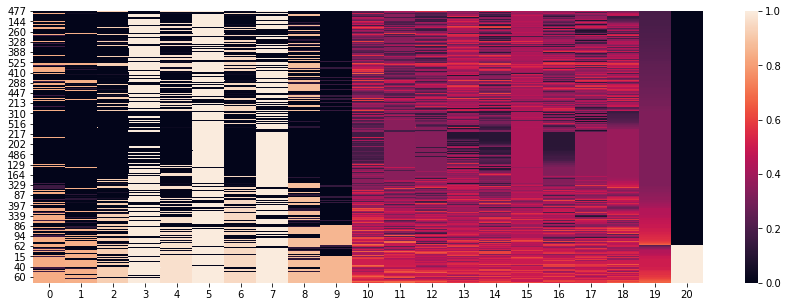

In [19]:
sort_array = [ item for sublist in [ (x, x+10) for x in range(0,10)] for item in sublist ][::-1]
sort_array.insert(0,20)
filled_plot = pd.DataFrame(filled_features)
sns.heatmap(filled_plot.sort_values(by=sort_array))

Ao salvar o dataset, iremos desconsiderar as colunas 2 e 12, pois elas correspondem a uma matéria para a qual não há um equivalente de mesma ementa na nova grade do curso ( Matemática Discreta ).

In [20]:
pd.DataFrame(filled_features)\
.drop(columns=[2,12])\
.to_csv('dataset.csv', index=False)

### Dataset com valores X(a,m)

Iremos carregar os valores $X_{a,m}$ e transformá-los em  $b(X_{a,m})$ para que possam servir de entrada ao modelo Bernoulli Naive Bayes.

In [21]:
dataset = pd.read_csv('dataset.csv')

Observamos os possíveis valores de $X_{a,m}$ em cada coluna e percebemos que eles podem ser satisfatoriamente aproximados por zero e um.

In [22]:
dataset_values = dataset.copy()

for idx, col in enumerate(dataset_values.columns):
    dataset_values[col] = dataset.iloc[:, idx].drop_duplicates()
    
dataset_values.iloc[:, 0:9]\
.apply(lambda x: pd.Series(x.dropna().values)).round(2)

,0,1,3,4,5,6,7,8,9
0,0.16,0.85,1.0,0.97,1.0,0.00,1.0,0.11,0.86
1,0.00,0.00,0.0,0.00,0.0,0.95,0.0,0.00,0.14
2,0.84,0.11,NaN,0.03,NaN,0.03,NaN,0.89,0.00
3,NaN,0.04,NaN,NaN,NaN,0.02,NaN,NaN,NaN


In [23]:
dataset_values.iloc[:, 0:9]\
.apply(lambda x: pd.Series(x.dropna().values)).fillna(0).round().astype(int)

,0,1,3,4,5,6,7,8,9
0,0,1,1,1,1,0,1,0,1
1,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0


In [24]:
dataset_left = dataset.iloc[:, 0:9].copy()
dataset_left = dataset_left.round().astype(int)
dataset_left['20'] = dataset['20'].astype(int)
dataset_left.head()

,0,1,3,4,5,6,7,8,9,20
0,0,1,1,1,1,0,1,0,1,1
1,0,0,1,0,1,1,1,0,0,1
2,0,1,0,1,1,1,1,0,1,1
3,0,0,1,1,1,0,1,0,1,1
4,0,1,1,0,1,1,1,0,1,1


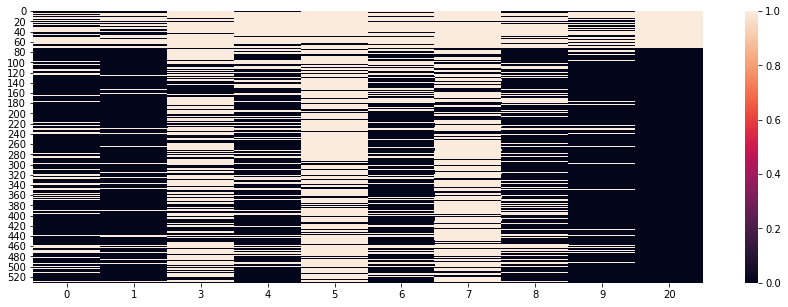

In [25]:
sns.heatmap(dataset_left)

In [26]:
dataset_left.to_csv('dataset_bernoulli.csv', index=False)

### Dataset com valores Y(a, m)

Carregamos os valores $Y_{a,m}$ e, após a observação dos histogramas de seus valores para cada matéria, percebemos a tendência a uma distribuição normal. Sendo assim, concluímos que o modelo mais adequado para esta parte dos dados seria Gaussian Naive Bayes.

In [27]:
dataset_right = dataset.iloc[:, 9:20].copy()
dataset_right.head()

,10,11,13,14,15,16,17,18,19,20
0,0.398750,0.638167,0.499926,0.458968,0.5,0.382155,0.577063,0.353357,0.554274,1.0
1,0.363824,0.438167,0.484926,0.403968,0.5,0.477155,0.577063,0.385214,0.370347,1.0
2,0.368750,0.498167,0.384926,0.413968,0.5,0.442155,0.542063,0.352357,0.494274,1.0
3,0.419706,0.448167,0.454926,0.448968,0.5,0.387155,0.452063,0.403952,0.519274,1.0
4,0.470614,0.498167,0.509926,0.378968,0.5,0.417155,0.442063,0.433952,0.584274,1.0


In [28]:
dataset_right.to_csv('dataset_gaussian.csv', index=False)

Plotaremos a distribuição dos valores de $Y_{a,m}$ dos bons alunos.

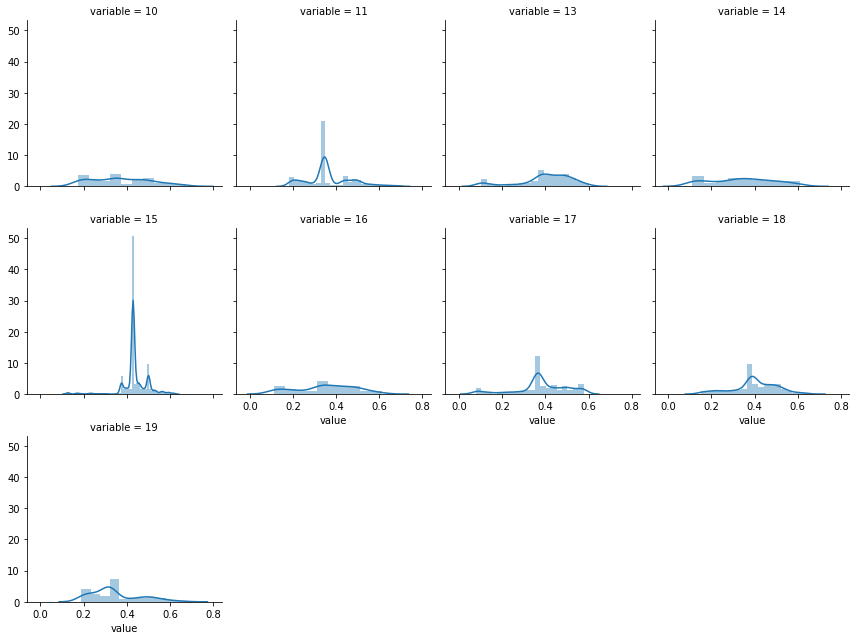

In [29]:
dataplot = dataset_right[dataset_right['20']==1]
dataplot = dataset_right[['10','11','13','14','15','16','17','18','19']]
g = sns.FacetGrid(dataplot.melt(), col="variable", col_wrap=4)
g.map(sns.distplot,"value")

Plotaremos a distribuição dos valores de $Y_{a,m}$ dos maus alunos.

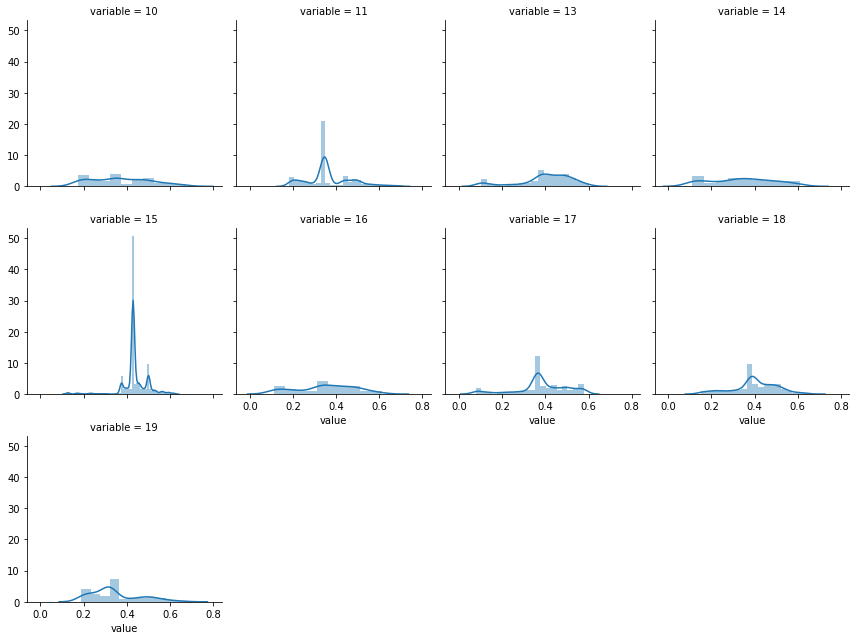

In [30]:
dataplot = dataset_right[dataset_right['20']==0]
dataplot = dataset_right[['10','11','13','14','15','16','17','18','19']]
g = sns.FacetGrid(dataplot.melt(), col="variable", col_wrap=4)

g.map(sns.distplot,"value")

## Treinamento e Classificação dos dados: Luana Guedes Barros Martins

Na parte de Tratamento de Dados, chegamos em dois datasets com diferentes comportamentos:

- dataset_guassian é composto por valores $Y_{a,m}$, que nos diz quanto um aluno se desviou da média dos bons alunos. Como podemos observar nos gráficos acima, essa variável possui valores que seguem uma distribuição normal em cada matéria. Portanto, para classificação desses dados será usado o algoritmo chamado Gaussian Naive Bayes, que é uma extensão do algoritmo Naive Bayes para atributos de valores reais, que assumem uma distribuição gaussiana.
- dataset_bernoulli é composto por valores $b(X_{a, m})$, que correspondem a um valor booleano que indica se o aluno $a$ passou ou não na matéria $m$ na sua primeira tentativa. Pela sua característica, observamos que $X_{a, m}$ possui valores muito distantes em cada matéria, sendo ou muito perto de 1 ou muito perto de 0, e por isso foram então transformados para valores inteiros aproximados, resultando em $b(X_{a,m})$. Para esses dados portanto será usado o algoritmo chamado Bernoulli Naive Bayes (também uma extensão do Naive Bayes), que, por sua vez, assume que todos os atributos são binários.

Com base nessa observação, usaremos dois classificadores, um para cada dataset de acordo com suas caracterísiticas. No final iremos utilizar os resultados das duas classificações e utilizar um classificador Bernoulli Naive Bayes para realizar um procedimento de votação entre as duas classificações afim de obter uma classificação final.

Nas implementações abaixo será usado a ferramenta [scikit learn](https://scikit-learn.org/stable/modules/naive_bayes.html). Sua implementação pode ser encontrada no [github](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/naive_bayes.py).

In [31]:
"""
Para auxiliar os dados de predição iremos utilizar essa 
função para plotar a matriz de confusão
"""
def plot_confusion_matrix(cm):
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    ax.set(ylabel='Valor verdadeiro')
    ax.set(xlabel='Valor previsto')
    labels = ['Verdadeiro Negativo', 
              'Falso Positivo', 
              'Falso Negativo', 
              'Verdadeiro Positivo']
    ax.set(yticklabels=['Negativo','Positivo'])
    ax.set(xticklabels=['Negativo','Positivo'])

    count = 0
    bacc = []
    for idx, text in enumerate(ax.texts):
        label = int(text.get_text())
        count += label
        bacc.append(label)

    acc1 = bacc[0] / ( bacc[0] + bacc[2] )
    acc2 = bacc[3] / ( bacc[1] + bacc[3] ) 
    balanced_accuracy = ( acc1 + acc2 ) / 2
    for idx,text in enumerate(ax.texts):
        square = text.get_text()
        percent = int(text.get_text()) / count
        percent = "{0:.0%}".format(percent)
        box_text = "{0}: \n \n {1} \n \n {2}".format(labels[idx], square, percent)
        text.set_text(box_text)
    ax.set_title('Matriz de Confusão')

In [32]:
# seed usada para de forma aleatória realizar a sepação do conjunto de dados em treino e teste
random_number = random.randint(0, 1000000)

### Naive Bayes

Os métodos de classificação Naive Bayes são um conjunto de aprendizado supervisionado baseados no Teorema de Bayes, onde assume-se uma independência entre os dados. Um classificador Naive Bayes assume que a presença de uma característica particular em uma classe não está relacionada com a presença de qualquer outro atributo. 

O Teorema de Bayes nos permite calcular a probabilidade posterior $P(C|x)$ dado a seguinte equação:

$$P(C|x) = \frac{P(x|C)P(C)}{P(x)}$$

Onde $C$ é a classe que estamos analisando e $x$ os dados de entrada ou observação. A equação acima é a "probabilidade posterior", que é a probabilidade da classe C após ter visto a observação x. Dado a probabilidade posterior de várias classes, podemos decidir qual é a mais provável. 

Como o denominador é o mesmo para todas as classes, podemos simplificar o cálculo comparando apenas o numerador. Para encontrar $P(C)$ basta contar a frequência de cada classe e obter a proporção dividindo pelo número de exemplos.

Para classificar uma nova observação, basta escolher o valor da classe $c$ para o qual $P(x_1, x_2, ..., x_n|c)$ é o mais alto:

$$Classifier(x_1, x_2, ..., x_n) = max_{C\in{0,1}} P(x_1, x_2, ..., x_n|c)$$

#### Gaussian Naive Bayes

Guassian Naive Bayes é usado quanto nossos dados possuem uma distribuição normal. Sua fórmula da probabilidade condicional é dada por:

$$P(x_i|C = c) = \frac{1}{\sqrt{2\pi\sigma_c^2}}exp\left(-\frac{(x_i-\mu_c)^2}{2\sigma_c^2}\right)$$

Onde os parâmetros $\sigma_c$ e $\mu_c$ são estimados durante o treinamento, e cada um representa, respectivamente, a variância do valor de $x$ calculado para uma dada classe $c$. Portanto, temos que encontrar a média e o desvio padrão dos conjuntos de dados para as diferentes classificações.

O classificador sklearn.naive_bayes.GaussianNB(), pode receber os seguintes parâmetros:
- priors: probabilidades a priori(anterior) das classes. Se for especificado, os antecendentes não serão ajustados de acordo com os dados.
- var_smoothing: porção da maior variação de todos os atributos adicionados às variações para estabilidade do cálculo. Por padrão var_smoothins será igual a 1e-9.


Após setados esses parâmetros, podemos utilizar a função fit(X, y) que realiza os seguintes passos:
- Recebe como parâmetros os valores X e y que correspondem respectivamente aos conjuntos de valores de treinamento e suas classificações.
- Verifica que os tamanhos de X e y são compatíveis.
- Calcula os valores que serão usados para calcular a probabilidade condicional, dado a fórmula especificada acima:

In [33]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

# Carregar dataset
dataset_gaussian = pd.read_csv('dataset_gaussian.csv')

# Separa os dados em um conjunto de valores e uma lista de classificação
X = dataset_gaussian.iloc[:, 0:-1].values.tolist()
y = np.array(dataset_gaussian.iloc[:, -1].values.tolist()).flatten()

# Separa os dados em cojuntos de teste e treinamento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = random_number)

# Instância a Gaussian Naive Bayes
gnb = GaussianNB()

# Realiza o ajusto dos parâmetros
gnb.fit(X_train, y_train)

# Atributos da Guassian Naive Bayes depois de treinada
print('\n-> Probabilidade de cada classe [0, 1]')
print(gnb.class_prior_)

print('\n-> Número de samples de treinamento observado em cada classe [0, 1]')
print(gnb.class_count_)

print('\n-> Média de cada atributo por classe')
print('  Classe 0:\n', gnb.theta_[0])
print('  Classe 1:\n', gnb.theta_[1])

print('\n-> Variância de cada atributo por classe')
print('  Classe 0:\n', gnb.sigma_[0])
print('  Classe 1:\n', gnb.sigma_[1])

print('\n-> Valor aditivo absoluto às variações')
print(gnb.epsilon_)


-> Probabilidade de cada classe [0, 1]
[0.86827957 0.13172043]

-> Número de samples de treinamento observado em cada classe [0, 1]
[323.  49.]

-> Média de cada atributo por classe
  Classe 0:
 [0.34975894 0.34349321 0.38493153 0.31618846 0.43018394 0.32977151
 0.36678992 0.38292133 0.31734951]
  Classe 1:
 [0.49894243 0.49653945 0.50941927 0.50349605 0.48901701 0.48766529
 0.49262715 0.49839159 0.49353671]

-> Variância de cada atributo por classe
  Classe 0:
 [0.01616836 0.00766199 0.01584923 0.01832599 0.00288837 0.01715607
 0.0134525  0.00972386 0.00901972]
  Classe 1:
 [0.0080148  0.01002775 0.00345734 0.00487035 0.00223966 0.0063627
 0.0040278  0.00513548 0.00746587]

-> Valor aditivo absoluto às variações
2.0566183826418075e-11


Para realizar a classificação, como já descrito, pega-se o valor da classe $c$ para o qual $P(x_1, x_2, ..., x_n|c)$ é o mais alto, dado a fórmula da probabilidade condicional para a Gaussian Naive Bayes.

In [34]:
# Retorna a média da acurácia dado um conjunto de dados de teste
print("Acurácia: ", round(gnb.score(X_test, y_test)*100, 2), "%")

Acurácia:  90.0 %


In [35]:
# Realiza a classificação de um conjunto de dados de teste 
gaussian_predictions = gnb.predict(X_test)

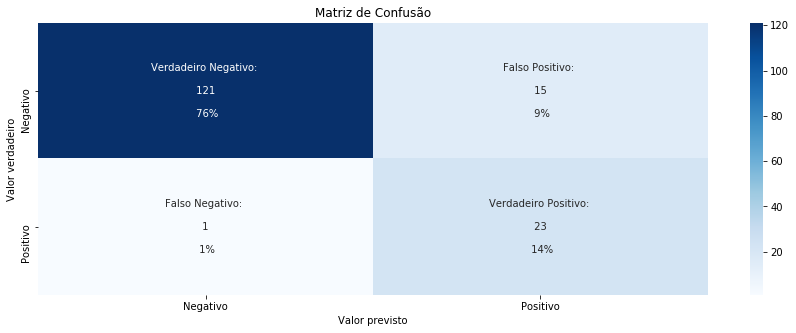

In [36]:
# Plota a matriz de confusão
cm = confusion_matrix(y_test, gaussian_predictions)
plot_confusion_matrix(cm)

In [37]:
# Cálculo da acurácia total dado a matriz de confusão
value = ( cm[0][0] + cm[1][1] ) / ( cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
value = "{0:.0%}".format(value)
print('Acurácia total : ', value )

Acurácia total :  90%


In [38]:
# Cálculo da acurácia de falso positivo/verdadeiro positivo dado a matriz de confusão
value = ( cm[1][1] ) / ( cm[0][1] + cm[1][1]) 
value = "{0:.0%}".format(value)
print('Acurácia de distinção entre Falso positivo / Verdadeiro positivo :\n', value )

Acurácia de distinção entre Falso positivo / Verdadeiro positivo :
 61%


#### Bernoulli Naive Bayes

Bernoulli Naive Bayes é utilizado para atributos que assumem valores binários/boleanos. Sua fórmula da probabilidade condicional é dada por:

$$P(x_i|C = c) = P(i|c)x_i + (1 - P(i|c))(1 - x_i)$$

A fórmula de Bernoulli Naive Bayes penaliza a não ocorrência de uma característica $i$ que é um indicador para a classe $c$.

Dado um conjunto de dados, cada atributo $i$ corresponde aos valores $x_i$. A dimensão $i$ de um vetor do conjunto de dados irá indicar se o aluno correspondente a este vetor passou ou não na matéria $i$ em sua primeira tentativa. A probabilidade de cada $x_i$ é independente da ocorrência de outros $x_i$ em uma observação. E, a probabilidade de uma observação receber sua classe, é o produto da probabilidade dos valores de atributo sobre todos os atributos.

O classificador sklearn.naive_bayes.BernoulliNB() pode receber os seguintes parâmetros:
- alpha: parâmetro de suavização. Seu valor padrão é igual a 1.0.
- binarize: limiar para binarização do conjunto de dados. Se esse atributo não for definido, presume-se que os dados já consistem em valores binários.
- fit_prior: para aprender as probabilidades a priori(anterior) da classe ou não. Seu valor padrão é verdadeiro, porém se falso, uma probabilidade a priori uniforme será usada.
- class_prior: probabilidades a priori das classes. Se for especificado, os antecendentes não serão ajustados de acordo com os dados.

Após setados esses parâmetros, podemos utilizar a função fit(X, y) que realiza os seguintes passos:
- Recebe como parâmetros os valores X e y que correspondem respectivamente aos conjuntos de valores de treinamento e suas classificações.
- Verifica que os tamanhos de X e Y são compatíveis.
- Calcula os valores que serão usados para calcular a probabilidade condicional, dado a fórmula especificada acima.

In [39]:
from sklearn.naive_bayes import BernoulliNB

# Carrega o dataset
dataset_bernoulli = pd.read_csv('dataset_bernoulli.csv')

# Separa os dados em um conjunto de valores e uma lista de classificação
X = dataset_bernoulli.iloc[:, 0:-1].values.tolist()
y = np.array(dataset_bernoulli.iloc[:, -1].values.tolist()).flatten()

# Separa os dados em um conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = random_number)

# Instância o Bernoulli Naive Bayes
bnb = BernoulliNB()

# Realiza o ajusto dos parâmetros
bnb.fit(X_train, y_train)

# Atributos do Bernoulli Naive Bayes depois de treinado
print('\n-> Probabilidade logarítmica de cada classe (suavizada)')
print(bnb.class_log_prior_)

print('\n-> Probabilidade logarítmica empírica dos atributos dado uma classe, P(x_i|y)')
print('  Classe 0:\n', bnb.feature_log_prob_[0])
print('  Classe 1:\n', bnb.feature_log_prob_[1])

print('\n-> Número de amostras encontradas para cada classe.')
print(bnb.class_count_)

print('\n-> Número de amostras encontradas para cada (classe, atributo).')
print('  Classe 0:\n', bnb.feature_count_[0])
print('  Classe 1:\n', bnb.feature_count_[1])


-> Probabilidade logarítmica de cada classe (suavizada)
[-0.14124153 -2.02707356]

-> Probabilidade logarítmica empírica dos atributos dado uma classe, P(x_i|y)
  Classe 0:
 [-1.59417044 -2.41652935 -0.50571052 -1.36498457 -0.1891138  -1.2091142
 -0.34140747 -1.41437733 -2.52572864]
  Classe 1:
 [-0.46608973 -0.43531807 -0.10318424 -0.147636   -0.17062552 -0.19415601
 -0.08167803 -0.29423947 -0.40546511]

-> Número de amostras encontradas para cada classe.
[323.  49.]

-> Número de amostras encontradas para cada (classe, atributo).
  Classe 0:
 [ 65.  28. 195.  82. 268.  96. 230.  78.  25.]
  Classe 1:
 [31. 32. 45. 43. 42. 41. 46. 37. 33.]


Para realizar a classificação, como já descrito, pega-se o valor da classe $c$ para o qual $P(x_1, x_2, ..., x_n|c)$ é o mais alto, dado a fórmula da probabilidade condicional para o Bernoulli Naive Bayes.

In [40]:
# Retorna a média da acurácia dado um conjunto de dados de teste
print("Acurácia: ", round(bnb.score(X_test, y_test)*100, 2), "%")

Acurácia:  88.75 %


In [41]:
# Realiza a classificação de um conjunto de dados de teste 
bernoulli_predictions = bnb.predict(X_test)

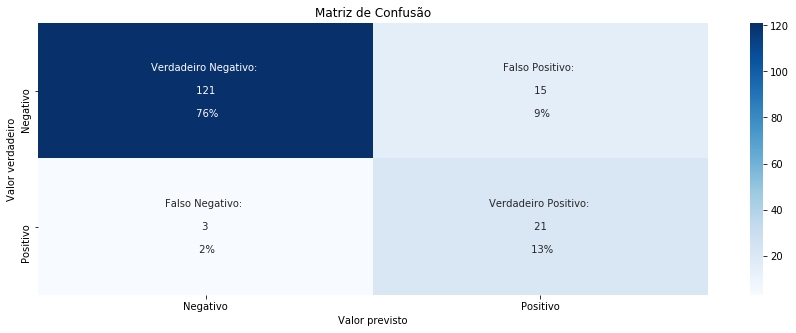

In [42]:
# Plota a matriz de confusão
cm = confusion_matrix(y_test, bernoulli_predictions)
plot_confusion_matrix(cm)

In [43]:
# Cálculo da acurácia total dado a matriz de confusão
value = ( cm[0][0] + cm[1][1] ) / ( cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
value = "{0:.0%}".format(value)
print('Acurácia total : ', value )

Acurácia total :  89%


In [44]:
# Cálculo da acurácia de falso positivo/verdadeiro positvo dado a matriz de confusão
value = ( cm[1][1] ) / ( cm[0][1] + cm[1][1]) 
value = "{0:.0%}".format(value)
print('Acurácia de distinção entre Falso positivo / Verdadeiro positivo :\n', value )

Acurácia de distinção entre Falso positivo / Verdadeiro positivo :
 58%


### Classificação Final
Uma vez realizado as predições dos conjuntos de teste para ambos os datasets, iremos utilizar essas predições para avaliar a classificação final utilizando o Bernoulli Naive Bayes. Cada um dos conjuntos de predições irá corresponder a um atributo do novo dataset que estamos criando, e suas respostas (última coluna) serão as mesmas obtidas do dataset original.

In [45]:
# Classificação da Gaussian Naive Bayes
col1 = gaussian_predictions.reshape(-1,1)

# Classificação do Bernoulli Naive Bayes
col2 = bernoulli_predictions.reshape(-1,1)

# Classificações do conjunto de dados de teste
col3 = y_test.reshape(-1,1)

# Concatenando
col1 = pd.DataFrame(col1).astype(int)
col2 = pd.DataFrame(col2)
col3 = pd.DataFrame(col3)
combination = pd.concat([col1, col2, col3], axis=1)

combination.head()

,0,0,0
0,0,0,0
1,0,0,0
2,1,1,1
3,0,0,0
4,0,0,0


In [46]:
# Separa os dados em um conjunto de valores e uma lista de classificação
X = combination.iloc[:, 0:-1].values.tolist()
y = np.array(combination.iloc[:, -1].values.tolist()).flatten()

# Separa os dados em um conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Instância o Bernoulli Naive Bayes
combined_bnb = BernoulliNB()

# Realiza o ajusto dos parâmetros
combined_bnb.fit(X_train, y_train)

# Atributos do Bernoulli Naive Bayes depois de treinado
print('\n-> Probabilidade logarítmica de cada classe (suavizada)')
print(bnb.class_log_prior_)

print('\n-> Probabilidade logarítmica empírica dos atributos dado uma classe, P(x_i|y)')
print('  Classe 0:\n', bnb.feature_log_prob_[0])
print('  Classe 1:\n', bnb.feature_log_prob_[1])

print('\n-> Número de amostras encontradas para cada classe.')
print(bnb.class_count_)

print('\n-> Número de amostras encontradas para cada (classe, atributo).')
print('  Classe 0:\n', bnb.feature_count_[0])
print('  Classe 1:\n', bnb.feature_count_[1])


-> Probabilidade logarítmica de cada classe (suavizada)
[-0.14124153 -2.02707356]

-> Probabilidade logarítmica empírica dos atributos dado uma classe, P(x_i|y)
  Classe 0:
 [-1.59417044 -2.41652935 -0.50571052 -1.36498457 -0.1891138  -1.2091142
 -0.34140747 -1.41437733 -2.52572864]
  Classe 1:
 [-0.46608973 -0.43531807 -0.10318424 -0.147636   -0.17062552 -0.19415601
 -0.08167803 -0.29423947 -0.40546511]

-> Número de amostras encontradas para cada classe.
[323.  49.]

-> Número de amostras encontradas para cada (classe, atributo).
  Classe 0:
 [ 65.  28. 195.  82. 268.  96. 230.  78.  25.]
  Classe 1:
 [31. 32. 45. 43. 42. 41. 46. 37. 33.]


In [47]:
# Retorna a média da acurácia dado um conjunto de dados de teste
print("Acurácia: ", round(combined_bnb.score(X_test, y_test)*100, 2), "%")

Acurácia:  89.58 %


In [48]:
# Realiza a classificação de um conjunto de dados de teste 
combined_predictions = combined_bnb.predict(X_test)

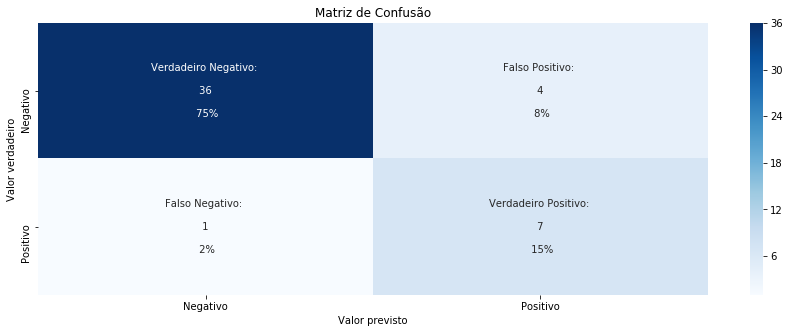

In [49]:
# Plota a matriz de confusão
cm = confusion_matrix(y_test, combined_predictions)
plot_confusion_matrix(cm)

In [50]:
# Cálculo da acurácia total dado a matriz de confusão
value = ( cm[0][0] + cm[1][1] ) / ( cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
value = "{0:.0%}".format(value)
print('Acurácia total : ', value )

Acurácia total :  90%


In [51]:
# Cálculo da acurácia de falso positivo/verdadeiro positivo dado a matriz de confusão
value = ( cm[1][1] ) / ( cm[0][1] + cm[1][1]) 
value = "{0:.0%}".format(value)
print('Acurácia de distinção entre Falso positivo / Verdadeiro positivo :\n', value )

Acurácia de distinção entre Falso positivo / Verdadeiro positivo :
 64%
